# **Interpretable Machine Learning with LIME**

## Imports

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler



# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# **Load data**

# Data Loaders

In [3]:
def get_train_valid_loader(data_dir,
                           batch_size,#to allow parallelization
                           augment,#wether augmentation is applied or not
                           random_seed,
                           valid_size=0.1,
                           shuffle=True):

    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transformation to be applied on validation data
    valid_transform = transforms.Compose([
            transforms.CenterCrop(min(277,277)),  # Center crop to a square
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            normalize,
    ])

    if augment: #apply data augmentation technique
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])
    else:
        train_transform = transforms.Compose([
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            normalize,
        ])

    # load the dataset and apply the transformation
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=train_transform,
    )

    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=valid_transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler)

    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return (train_loader, valid_loader)


def get_test_loader(data_dir, batch_size,shuffle=True):

    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )

    # define transform
    transform = transforms.Compose([
        transforms.Resize((227,227)),
        transforms.ToTensor(),
        normalize,
    ])

    dataset = datasets.CIFAR10(
        root=data_dir, train=False,
        download=True, transform=transform,
    )

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle
    )

    return data_loader


# CIFAR10 dataset
train_loader, valid_loader = get_train_valid_loader(data_dir = './data', batch_size = 120,augment = False,  random_seed = 1)

test_loader = get_test_loader(data_dir = './data', batch_size = 120)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# **Fit an interpretable model**

## **Building the AlexNet classifier (Blackbox Model)**



In [4]:

class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [5]:
num_classes = 10
num_epochs = 20
batch_size = 120
learning_rate = 0.005

model = AlexNet(num_classes).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)


# Train the model
total_step = len(train_loader)

In [ ]:

total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs

        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total))

KeyboardInterrupt: ignored

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

   # print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))

KeyboardInterrupt: ignored

# **Selecting an instance to explain**

In [7]:
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

def visualize_image(image):

    mean = [0.4914, 0.4822, 0.4465]
    std = [0.2023, 0.1994, 0.2010]
    # Create a denormalization transform
    denormalize = transforms.Normalize(mean=[-m/s for m, s in zip(mean, std)],
                                      std=[1/s for s in std])
    imagev =  denormalize(image)

    # Convert the image from a PyTorch tensor to a NumPy array
    imagev = imagev.numpy().transpose((1, 2, 0))#move the 1st dim to the last to be compatible with imgshow

    # Clip values to [0, 1] range in case of any rounding errors
    imagev = np.clip(imagev, 0, 1)

    # Plot the image using matplotlib
    plt.imshow(imagev)
    plt.axis('off')
    plt.show()


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


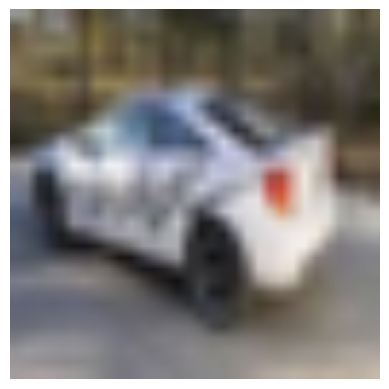

In [11]:

train_loader, valid_loader = get_train_valid_loader(data_dir = './data', batch_size = 120,augment = False,  random_seed = 1)

test_loader = get_test_loader(data_dir = './data', batch_size = 120)

#extract training dataset from the loader
train_dataset = train_loader.dataset
cifar10_labels = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
]
#select an image from the dataset
index = 980
image, label = train_dataset[index]
#visualize the selected image
visualize_image(image)
print("the predicted label is:",cifar10_labels[label])

# **Segmentation into Superpixels**

In [8]:
import numpy as np
from skimage.segmentation import quickshift
import matplotlib.pyplot as plt

def get_reduced_image(image):
    """
    Reduce the image to represent each superpixel with its mean color.

    Parameters:
        image (numpy array): Input image as a numpy array.

    Returns:
        reduced_image (numpy array): Array containing the mean color for each superpixel.
    """
    # Transform the pytorch tensor into a numpy array
    image_numpy = image.numpy().transpose((1, 2, 0))

    # Apply Quickshift to get the segments
    segments = quickshift(image_numpy, ratio=1.0, kernel_size=5, max_dist=10, return_tree=False)

    reduced_colors = []

    for label in np.unique(segments):
        mean_color = np.mean(image_numpy[segments == label], axis=0)  # Calculate the mean color for the current superpixel for each channel seperately
        reduced_colors.append(mean_color)  # Append the mean color to the list

    reduced_image = np.array(reduced_colors)  # Convert the list to a numpy array

    # Visualize the superpixels
    segmented_image = np.zeros_like(image_numpy)

    for label in np.unique(segments):
        segmented_image[segments == label] = reduced_image[label]  # Assign the mean color to each superpixel

    plt.imshow(segmented_image)
    plt.axis('off')
    plt.show()
    print("shape of mean color numpy :",mean_color.shape)

    return reduced_image,segments


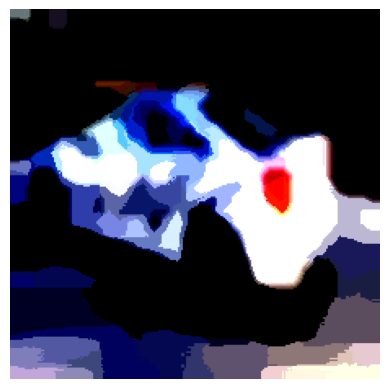

shape of mean color numpy : (3,)
reduced features (412, 3)


In [12]:
#reduce features of an image #445358
reduced_img,segments = get_reduced_image(image)
print("reduced features",reduced_img.shape)

## **LIME Explanations**

### **Step 1**. Generate random perturbations around the instance being explained

In [13]:
import random
import torch

# Generate perturbed images based on the segmentation
num_perturbations = 1000
perturbed_images = []

for _ in range(num_perturbations):
    perturbed_image = image.clone()  # Create a copy of the original image as a PyTorch tensor

    for label in np.unique(segments):
        random_number = random.random()

        # Set the pixel values within the superpixel based on the random number
        if random_number < 0.5:
            perturbed_image[:, segments == label] = 0.0

    perturbed_images.append(perturbed_image)

perturbed_images = torch.stack(perturbed_images)
# 'perturbed_images' is now a PyTorch tensor containing the perturbed images



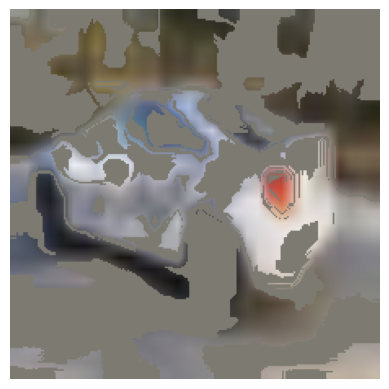

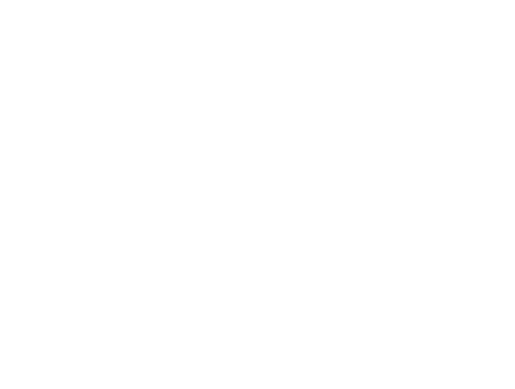

In [14]:
# Visualize the first perturbed image (You can convert it back to NumPy for visualization)
visualize_image(perturbed_images[random.randint(0, 100)])
plt.axis('off')
plt.show()

In [15]:
#reduce the perturbed images
def reduce_image(image,segments):#use the same segmentation of the original image to have the same number of features
    """
    Reduce the perturbed image to represent each superpixel with its mean color.

    Parameters:
        image (numpy array): Input image as a numpy array.

    Returns:
        reduced_image (numpy array): Array containing the mean color for each superpixel.
    """
    # Transform the pytorch tensor into a numpy array
    image_numpy = image.numpy().transpose((1, 2, 0))

    reduced_colors = []

    for label in np.unique(segments):
        mean_color = np.mean(image_numpy[segments == label], axis=0)  # Calculate the mean color for the current superpixel for each channel seperately
        reduced_colors.append(mean_color)  # Append the mean color to the list

    reduced_image = np.array(reduced_colors)  # Convert the list to a numpy array


    return reduced_image


In [31]:
reduced_images = np.empty((1000, 412, 3))

# Loop through each perturbed image and reduce it
for i in range(1000):
    reduced_image = reduce_image(perturbed_images[i],segments)
    reduced_images[i] = reduced_image


### **Step 2**: Use ML classifier to predict classes of new generated dataset

In [32]:
print(perturbed_images.shape)

torch.Size([1000, 3, 227, 227])


In [ ]:
images = perturbed_images.to(device) #we pass the pytorch array not the reduced images
outputs = model(images)
_, predictions = torch.max(outputs.data, 1)

In [ ]:
print("generated labels for perturbed dataset",predictions)

### **Step 3**: Compute distances between the instance being explained and each perturbation and compute weights (importance)

In [22]:
import numpy as np
import torch
from sklearn.metrics.pairwise import cosine_similarity

def cosine_distance(selected_image, perturbed_images):
    """
    Calculate the cosine distance between a selected image and a set of perturbed images represented as PyTorch tensors.

    Parameters:
        selected_image (torch.Tensor): The selected image represented as a tensor.
        perturbed_images (numpy array with shape (100, 3, 227, 227)): Set of perturbed images represented as NumPy arrays.

    Returns:
        distances (numpy array): Numpy array containing the cosine distances between the selected image and each perturbed image.
    """
    # Convert the PyTorch tensor to a NumPy array
    selected_image_numpy = selected_image.numpy().flatten()

    # Convert the perturbed_images from PyTorch tensors to NumPy arrays
    perturbed_images_numpy = perturbed_images.reshape(perturbed_images.shape[0], -1)

    # Calculate cosine similarity between the selected image and each perturbed image
    similarities = cosine_similarity([selected_image_numpy], perturbed_images_numpy)

    # Convert cosine similarity to cosine distance (1 - similarity)
    distances = 1 - similarities

    return distances[0].reshape(-1, 1)


In [23]:
# Calculate the cosine distance between the two images
distances = cosine_distance(image,perturbed_images)

print("Cosine Distances:", distances.shape)

Cosine Distances: (1000, 1)


In [24]:
#define a Kernel function
import numpy as np

def exponential_smoothing_kernel(distances, kernel_width):
    """
    Calculate the weights using an exponential smoothing kernel.

    Parameters:
        distances (numpy array): Array of distances between perturbed instances and the instance being explained.
        kernel_width (float): Width parameter for the exponential kernel.

    Returns:
        weights (numpy array): Array of weights assigned to the perturbed instances.
    """

    weights = np.exp(-0.5 * (distances / kernel_width) ** 2)
    return weights


In [26]:
# Calculate the weights using the exponential smoothing kernel
kernel_width = 2
weights = exponential_smoothing_kernel(distances, kernel_width)

# weights assigned to the perturbed images
print("Weights:", weights)

Weights: [[0.99182963]
 [0.9886711 ]
 [0.9847666 ]
 [0.99277   ]
 [0.98903674]
 [0.99369353]
 [0.99374825]
 [0.9931369 ]
 [0.99194974]
 [0.989219  ]
 [0.99173886]
 [0.99512357]
 [0.9775358 ]
 [0.98848087]
 [0.9829248 ]
 [0.99296224]
 [0.9916682 ]
 [0.9926229 ]
 [0.9881997 ]
 [0.98677117]
 [0.9953287 ]
 [0.9899975 ]
 [0.99335784]
 [0.98185915]
 [0.99100083]
 [0.993543  ]
 [0.9881069 ]
 [0.9918519 ]
 [0.9903732 ]
 [0.9872283 ]
 [0.9963515 ]
 [0.9931918 ]
 [0.9930396 ]
 [0.9897394 ]
 [0.98974746]
 [0.98268336]
 [0.98363775]
 [0.9939628 ]
 [0.99118966]
 [0.9907972 ]
 [0.9926977 ]
 [0.9815642 ]
 [0.9935226 ]
 [0.99149513]
 [0.9920585 ]
 [0.9849873 ]
 [0.9925255 ]
 [0.98490137]
 [0.9902715 ]
 [0.99292755]
 [0.9793954 ]
 [0.98805285]
 [0.9893092 ]
 [0.9953388 ]
 [0.99058074]
 [0.98988813]
 [0.99067205]
 [0.99145603]
 [0.99412847]
 [0.9921947 ]
 [0.9879665 ]
 [0.9857403 ]
 [0.98836505]
 [0.987827  ]
 [0.98154   ]
 [0.98283553]
 [0.9874307 ]
 [0.9885316 ]
 [0.9827031 ]
 [0.9891436 ]
 [0.9900208

In [29]:
weights = np.squeeze(weights)
print("weights shape",predictions.shape)
print(predictions.cpu().numpy())
print("predictions shape",predictions.cpu().numpy().shape)

weights shape torch.Size([1000])
[6 0 9 3 9 9 4 6 3 6 6 9 3 6 9 2 4 7 9 2 9 2 2 9 2 2 9 3 7 4 2 4 9 7 2 0 7
 3 2 4 9 7 2 2 7 6 6 7 6 9 2 6 2 7 7 9 6 6 6 3 9 6 2 4 6 0 9 2 6 2 9 7 4 2
 9 9 9 7 4 2 6 2 3 9 9 2 6 9 6 2 2 9 4 6 3 4 6 9 2 2 2 7 2 9 9 4 9 6 2 9 1
 3 6 9 6 2 6 2 2 6 9 2 7 2 2 4 2 6 3 9 9 9 9 6 2 2 4 6 9 6 6 2 2 9 6 3 9 2
 3 2 3 9 2 1 9 9 2 2 3 3 7 4 6 2 7 2 7 0 6 6 6 1 2 7 9 9 2 2 2 9 6 9 2 6 1
 9 6 6 2 1 9 8 2 9 9 9 2 3 2 9 6 2 3 9 9 9 6 9 2 2 9 3 6 6 2 6 6 2 4 9 2 4
 7 2 2 8 9 9 9 9 2 9 7 2 2 3 9 2 2 9 2 7 2 7 9 2 9 6 9 2 2 4 9 2 9 6 2 7 9
 9 3 6 9 2 6 3 0 2 9 4 7 9 4 6 9 2 0 6 2 2 2 6 2 2 2 9 9 9 6 9 9 2 9 1 1 6
 2 3 2 2 9 9 9 9 2 6 1 6 6 6 6 2 2 9 9 2 9 3 4 2 6 6 2 7 9 6 7 9 2 2 6 2 7
 9 9 6 2 2 2 9 8 9 6 9 3 6 2 2 2 7 3 9 2 9 7 9 3 2 2 9 2 9 9 3 2 9 3 6 3 3
 2 2 1 6 9 3 8 0 2 9 2 2 7 6 9 9 2 9 3 1 2 6 9 3 2 2 2 2 1 2 6 9 9 7 2 3 2
 1 7 1 7 2 3 7 3 7 9 2 2 9 6 9 2 8 2 6 9 9 9 2 7 0 9 8 3 7 9 2 2 9 9 9 7 6
 2 2 1 9 2 2 9 2 6 2 2 4 3 6 2 6 2 2 2 2 6 1 2 2 3 2 1 2 2 2 2 3 6 

### **Step 4**: Build a surrogate model

In [28]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Reshape the reduced_images
reduced_images_reshaped = reduced_images.reshape(reduced_images.shape[0], -1)
# Convert predictions tensor to a NumPy array
predictions_numpy = predictions.cpu().numpy()

# Create and fit the linear model (surrogate)
surrogate_model = LinearRegression()
surrogate_model.fit(reduced_images_reshaped, predictions_numpy, sample_weight=weights) # LIME uses a weighted least square


ValueError: ignored

In [30]:
print(reduced_images_reshaped.shape) #number of params for each image 159

(100, 1236)


# **Interpret the explanations**

## Interpret Coefficients

In [ ]:
#a list that represent the contribution of each superpixel
coefficients = surrogate_model.coef_
#a list of tuples
superpixel_contributions = list(zip(segments, coefficients))


In [ ]:
#print(coefficients)
reshaped_coef = coefficients.reshape((53,3)) #to reshape to the same shape as the reduced image
# Calculate the sum of all coefficients
coefficients_sum = np.sum(coefficients)
# Calculate the percentages for each coefficient
coefficients_percentages = (coefficients / coefficients_sum)
print(coefficients_percentages)
print("percentages",reshaped_coef.shape)

[-1.88023836e-01 -9.65599608e-01  1.05892527e+00 -1.65019584e-01
  2.72120080e-01 -9.87144146e-02  7.39538869e-01 -2.32034732e-01
 -4.17831381e-01  3.23568112e-01  7.69127541e-02 -3.13178485e-01
 -9.96311239e-02 -7.61089107e-02  6.04155025e-02 -9.71419054e-02
 -3.90449028e-02  1.24380635e-01  1.05422506e-01 -4.40946343e-02
 -2.88249902e-02  1.49633888e-02  5.65953442e-03  1.21416185e-02
  2.37046475e-01 -4.05484019e-01  1.76999210e-01 -6.95071166e-04
  4.15756978e-03  1.18848723e-03  6.07167363e-02 -5.19205022e-02
 -3.11939134e-02  3.20065881e-01 -4.58706558e-01  1.56823922e-01
  2.03535074e-02  4.01235592e-04  1.08057685e-02  7.95183894e-02
 -1.45191765e-01 -5.10048617e-02  2.78426637e-01  1.27410457e-01
 -2.44944049e-01  2.44107699e-02  1.90095508e-02 -1.70527932e-02
  5.23190554e-02  1.48441705e-01 -5.84496952e-02  3.43636199e-01
 -1.23379500e-01 -2.06103157e-01  5.07156385e-05 -3.59336603e-02
  3.51010722e-02 -4.38292444e-02  1.61160140e-01 -1.17877030e-01
  2.65894918e-01 -3.46992

# **Visualisation of the most informative superpixels**

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


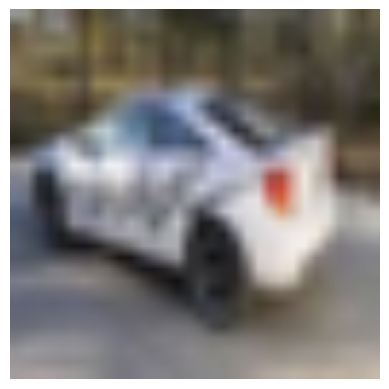

the predicted label is: automobile


In [ ]:
train_loader, valid_loader = get_train_valid_loader(data_dir = './data', batch_size = 120,augment = False,  random_seed = 1)

test_loader = get_test_loader(data_dir = './data', batch_size = 120)

#extract training dataset from the loader
train_dataset = train_loader.dataset
cifar10_labels = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
]
#select an image from the dataset
index = 980
image1, label = train_dataset[index]
#visualize the selected image
visualize_image(image1)
print("the predicted label is:",cifar10_labels[label])

In [ ]:
def visualize_importance(image,segments,coefficients_percentages):

    # Transform the pytorch tensor into a numpy array
    image_numpy = image.numpy().transpose((1, 2, 0))


    # Visualize the superpixels
    segmented_image = np.zeros_like(image_numpy)

    for label in np.unique(segments):
      if coefficients_percentages[label] < 0:
        color = [1, 0, 0]
        segmented_image[segments == label] = color #assign red
      elif coefficients_percentages[label] > 0:
        color = [0, 1, 0]
        segmented_image[segments == label] = color #assign green

    plt.imshow(segmented_image)
    plt.axis('off')
    plt.show()


    return reduced_image,segments

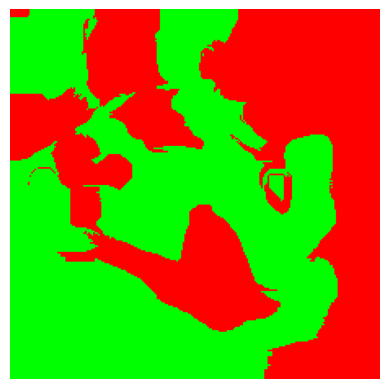

In [ ]:
reduced_img,segments = visualize_importance(image1,segments,coefficients_percentages)